In [1]:
# import packages
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
# from tsnecuda import TSNE
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn import metrics
from PIL import Image
from tqdm.notebook import tqdm
import pickle
import glob
import torch
import torch.nn as nn
from torchvision import transforms
from torchvision.models import resnet101
# set random seed
import random
random.seed(33)
np.random.seed(33)

In [2]:
proxy_flag = True
if proxy_flag:
    proxy = 'http://internet.ford.com:83'
    no_proxy = '.ford.com'
    os.environ['https_proxy'] = proxy
    os.environ['http_proxy'] = proxy
    os.environ['no_proxy'] = no_proxy

In [3]:
class TuSimpleObjectDataset(torch.utils.data.Dataset):
    def __init__(self, dataroot, mode = 'train',transform_fn = transforms.Compose([
                                        transforms.Resize((384, 384)), 
                                        transforms.ToTensor(),
                                        transforms.Normalize(0.5, 0.5),
                                      ]), verbose=True):
        if verbose: print('Loading Dataset...')
        self.dataroot = dataroot
        self.mode = mode
        self.transform_fn = transform_fn
        
        files = []
        main_dirs = sorted(os.listdir(os.path.join(self.dataroot,"clips")))
        for md in main_dirs:
            sub_dirs = sorted(os.listdir(os.path.join(self.dataroot,"clips",md)))
            for img_dir in sub_dirs:
                files_names = sorted(os.listdir(os.path.join(self.dataroot,"clips",md, img_dir)))
                for f in files_names:
                    if ".jpg" in f:
                        files.append(os.path.join(self.dataroot,"clips",md, img_dir,f))
                        
        self.files = files
        print('Number of data samples in TuSimple dataset: {}'.format(len(self.files)))
            
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        curr_img_path = self.files[idx]
        curr_img = Image.open(curr_img_path).convert('RGB')
        transform_img = self.transform_fn(curr_img)
        return {'image': transform_img, 'file_id': idx}

In [4]:
dataset_path = '/s/dat/UserFolders/xzhan258/LaneDetection/TuSimple'
dataset = TuSimpleObjectDataset(dataset_path, mode='train')

Loading Dataset...
Number of data samples in TuSimple dataset: 128159


In [5]:
dataset_str = 'tusimple'
features_fname = f'{dataset_str}_features.pkl'
tsne_features_fname = f'{dataset_str}_tsne_features.pkl'
batch_size = 64
num_workers = 32

In [95]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                         shuffle=False,num_workers=num_workers, pin_memory=True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# use a pre-trained model to get the feature vectors for all the images in the dataset
model = resnet101(pretrained=True, progress=True)
# remove the last layer keeping the weights
model = torch.nn.Sequential(*list(model.children())[:-1])
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model)

model = model.to(device)
model.eval()

Let's use 8 GPUs!


DataParallel(
  (module): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(

In [96]:
if not os.path.exists(features_fname):
    ids, features = [], []
    with torch.no_grad():
        for idx, data in enumerate(tqdm(dataloader)):
            img = data['image'].cuda()
            # inference
            feature = model(img).cpu().numpy()
            feature = feature.reshape(img.shape[0],-1)
            features.append(feature)
            ids.append(data['file_id'].cpu().numpy())

    features = np.concatenate(features, axis=0)
    features = np.asarray(features, dtype=np.float64)
    ids = np.concatenate(ids, axis=0)
    ids = np.asarray(ids, dtype=int)
    # save the features to disk as a pickle file
    with open(features_fname, 'wb') as f:
        pickle.dump({'ids': ids, 'features': features}, f)

  0%|          | 0/2003 [00:00<?, ?it/s]

In [6]:
# load the training features from disk
data = pickle.load(open(features_fname, 'rb'))
train_ids, train_features = data['ids'], data['features']

# picking every 20th sample
train_ids = train_ids[::20]
train_features = train_features[::20]

In [25]:
# project the features onto a 2D t-SNE plot
print('Projecting training dataset features to 2D...')
tsne = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=500, n_jobs=-1, init='pca')
tsne_results = tsne.fit_transform(train_features)
with open(tsne_features_fname, 'wb') as f:
    pickle.dump({'tsne':tsne_results},f)

Projecting training dataset features to 2D...
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 6408 samples in 0.009s...


/opt/conda/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computed neighbors for 6408 samples in 2.800s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6408
[t-SNE] Computed conditional probabilities for sample 2000 / 6408
[t-SNE] Computed conditional probabilities for sample 3000 / 6408
[t-SNE] Computed conditional probabilities for sample 4000 / 6408
[t-SNE] Computed conditional probabilities for sample 5000 / 6408
[t-SNE] Computed conditional probabilities for sample 6000 / 6408
[t-SNE] Computed conditional probabilities for sample 6408 / 6408
[t-SNE] Mean sigma: 2.471721


/opt/conda/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 79.930397
[t-SNE] KL divergence after 500 iterations: 1.443585


Number of clusters: 6


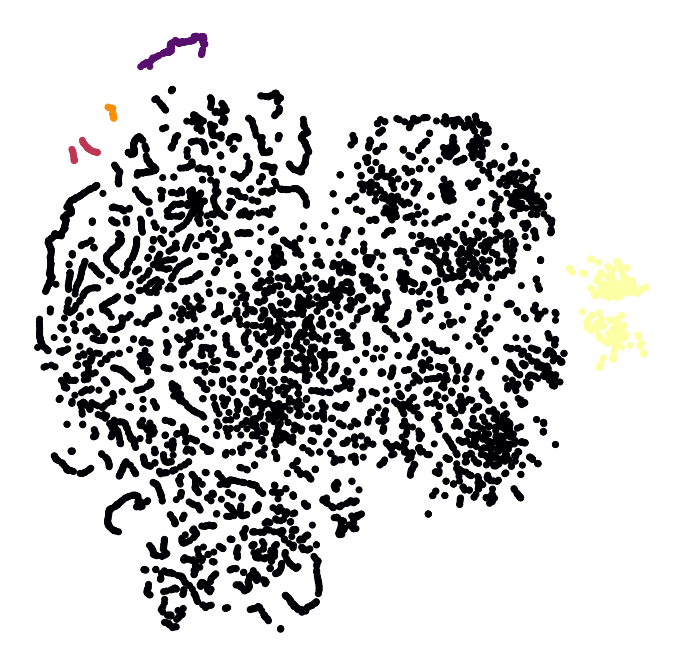

In [29]:
# find clusters using DBSCAN
data = pickle.load(open(tsne_features_fname, 'rb'))
tsne_results = data['tsne']
    
db = DBSCAN(eps=3.0, min_samples=10, n_jobs=-1).fit(tsne_results)
print('Number of clusters: {}'.format(len(np.unique(db.labels_))))
labels = db.labels_
# removing noisy samples
mask  = labels >=0
labels = labels[mask]
tsne_results = tsne_results[mask]
train_ids = train_ids[mask]
train_features = train_features[mask]
# visualize the clusters
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)
ax.scatter(tsne_results[:,0], tsne_results[:,1], c=labels, cmap='inferno')
plt.axis('off')
plt.savefig(f'plots/{dataset_str}_training_clusters.png', bbox_inches='tight', pad_inches=0)
plt.show()

In [30]:
# sort clusters in the order of most common to rare
unique_cluster_ids = np.unique(labels)
cluster_sizes = {cl_id: np.sum(labels == cl_id) for cl_id in unique_cluster_ids}
unique_cluster_ids = sorted(unique_cluster_ids, key=lambda i: cluster_sizes[i])
largest_cluster_size = cluster_sizes[unique_cluster_ids[-1]]

In [31]:
# get the cluster id and cluster size for each image
train_cluster_info_fname = f'{dataset_str}_training_cluster_info.pkl'
train_dataset_cluster_info = {}
for i in range(len(train_ids)):
    cluster_info = {'cluster_id': labels[i], 
                    'cluster_size': np.sum(labels == labels[i]),
                    'largest_cluster_size': largest_cluster_size}
    train_dataset_cluster_info[train_ids[i]] = cluster_info
# save the cluster info to disk
with open(train_cluster_info_fname, 'wb') as f:
    pickle.dump(train_dataset_cluster_info, f)
    print('Saved training cluster info to {}'.format(train_cluster_info_fname))

Saved training cluster info to tusimple_training_cluster_info.pkl


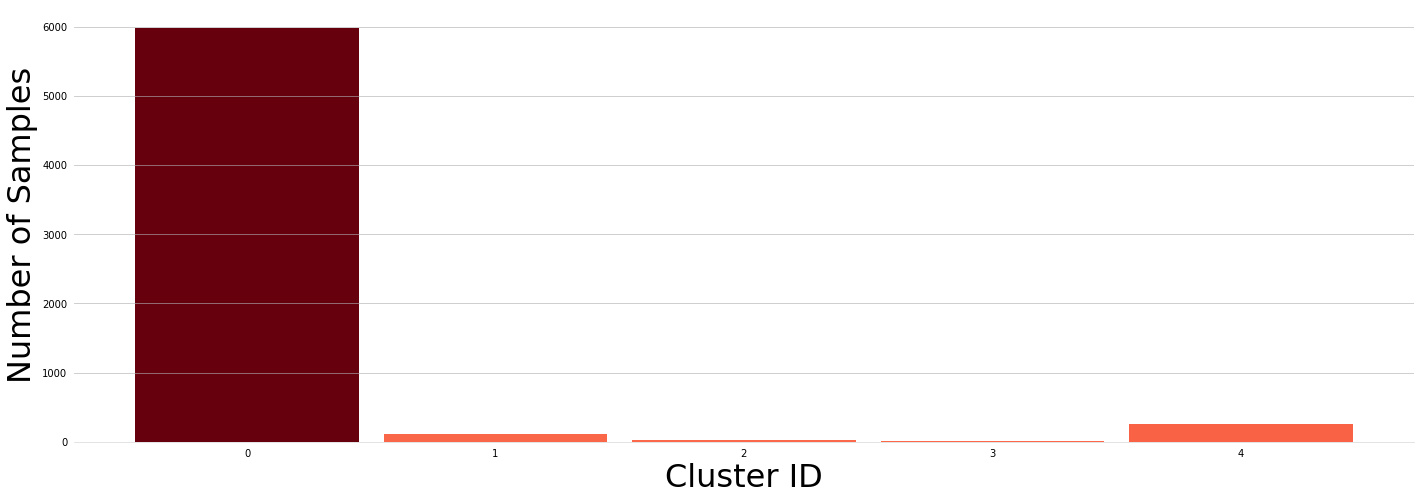

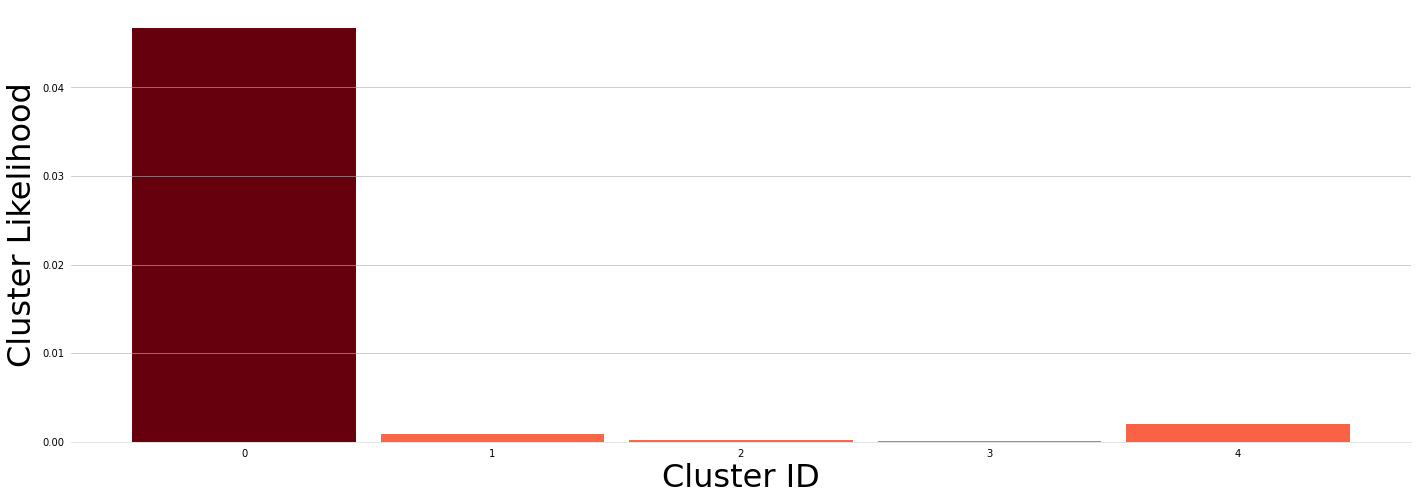

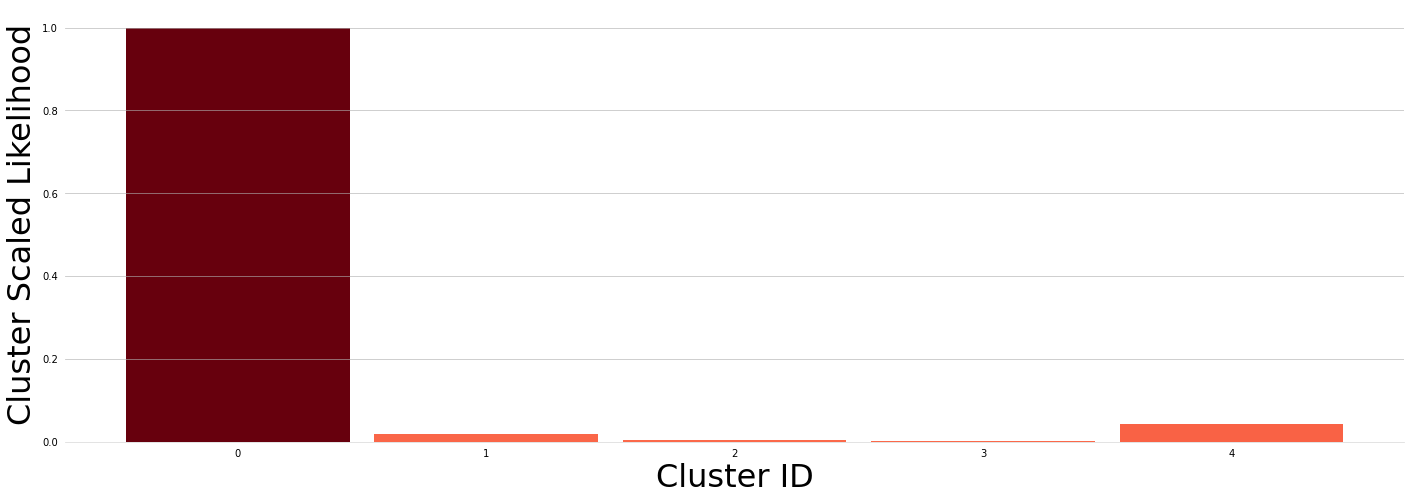

In [32]:
id_list, n_samples, sample_likelihood, sample_scaled_likelihood = \
    [], [], [], []
for i in range(len(np.unique(labels))):
    cluster_ids = np.array(train_ids)[labels == i]
    id_list.append(i)
    n_samples.append(len(cluster_ids))
    sample_likelihood.append(len(cluster_ids) / len(dataset))
    sample_scaled_likelihood.append(len(cluster_ids) / largest_cluster_size)


# plot histogram
fig, ax = plt.subplots(figsize=(24, 8))
# color each bar based on its height and color as hue of red
colors = plt.cm.Reds(0.5 + np.array(n_samples) / (2 * np.max(n_samples)))
ax.bar(id_list, n_samples, width = 0.9, color=colors)
ax.grid(axis='y', alpha=0.75)

ax.set_xlabel('Cluster ID', fontsize=32)
ax.set_ylabel('Number of Samples', fontsize=32)

# let's remove the top, right and left spines (figure borders)
# Also, make the bottom spine gray instead of black.
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#DDDDDD')

# remove the ticks as well.
ax.tick_params(bottom=False, left=False)
plt.show()

# plot cluster sample likelihood
fig, ax = plt.subplots(figsize=(24, 8))
# color each bar based on its height and color as hue of red
colors = plt.cm.Reds(0.5 + np.array(sample_likelihood) / (2 * np.max(sample_likelihood)))
ax.bar(id_list, sample_likelihood, width = 0.9, color=colors)
ax.grid(axis='y', alpha=0.75)

ax.set_xlabel('Cluster ID', fontsize=32)
ax.set_ylabel('Cluster Likelihood', fontsize=32)

# let's remove the top, right and left spines (figure borders)
# Also, make the bottom spine gray instead of black.
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#DDDDDD')

# remove the ticks as well.
ax.tick_params(bottom=False, left=False)
plt.show()

# plot cluster sample likelihood
fig, ax = plt.subplots(figsize=(24, 8))
# color each bar based on its height and color as hue of red
colors = plt.cm.Reds(0.5 + np.array(sample_scaled_likelihood) / (2 * np.max(sample_scaled_likelihood)))
ax.bar(id_list, sample_scaled_likelihood, width = 0.9, color=colors)
ax.grid(axis='y', alpha=0.75)

ax.set_xlabel('Cluster ID', fontsize=32)
ax.set_ylabel('Cluster Scaled Likelihood', fontsize=32)

# let's remove the top, right and left spines (figure borders)
# Also, make the bottom spine gray instead of black.
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#DDDDDD')

# remove the ticks as well.
ax.tick_params(bottom=False, left=False)
plt.savefig(f'plots/{dataset_str}_dataset_likelihood.png')
plt.show()

Visualizing rarest clusters of dataset samples...


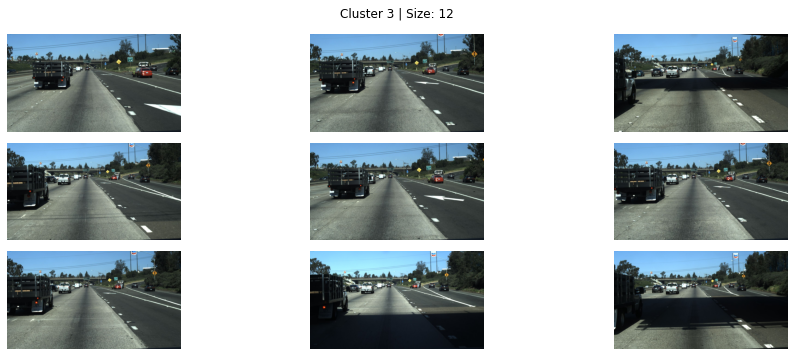

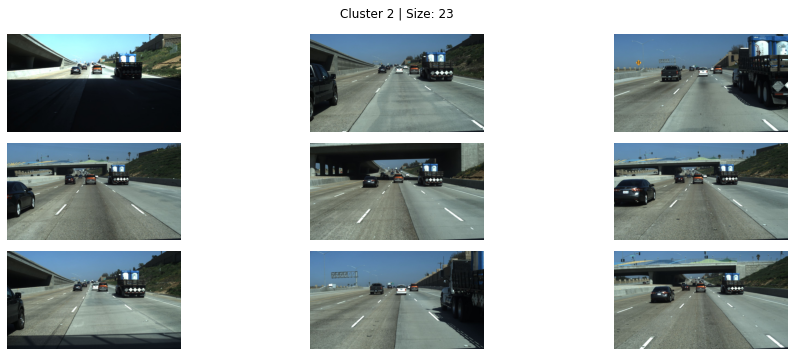

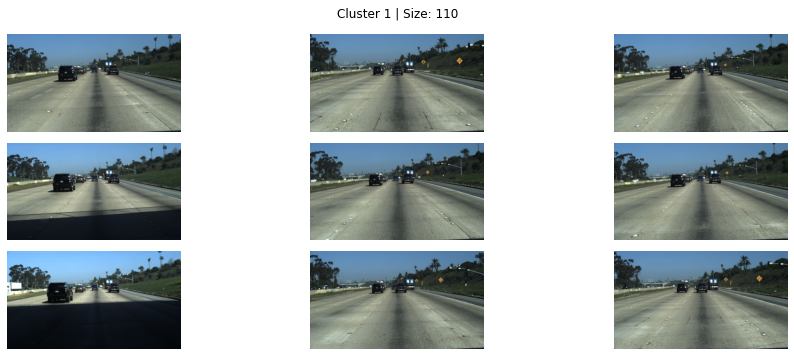

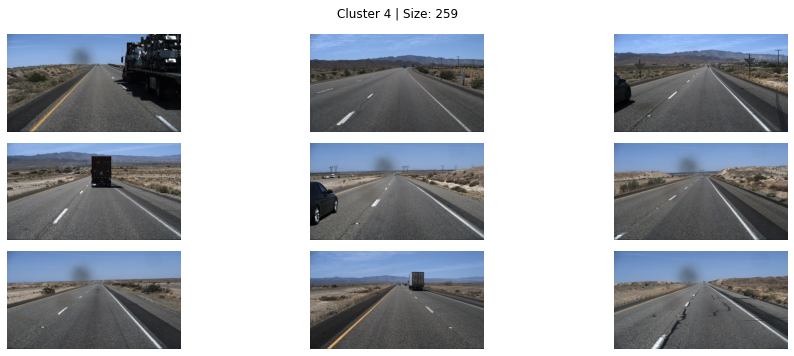

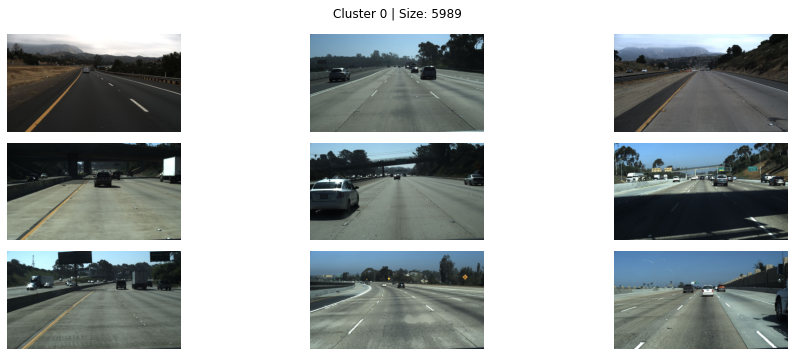

Visualizing most likely clusters of dataset samples...


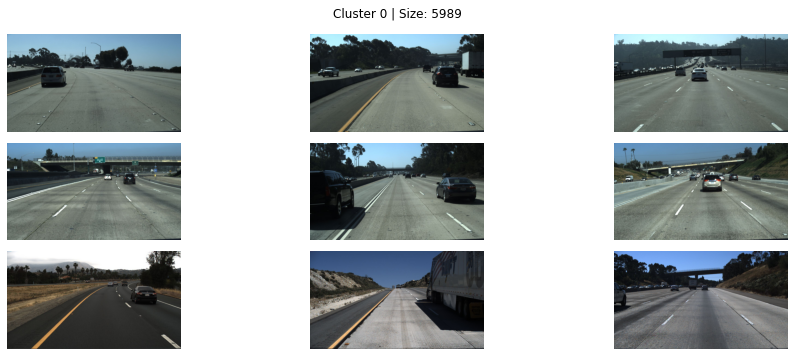

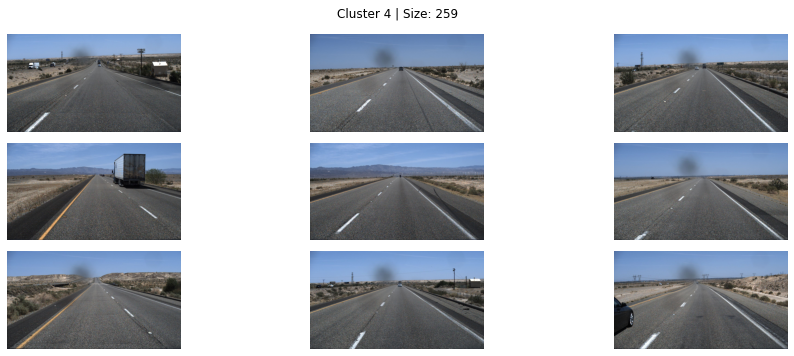

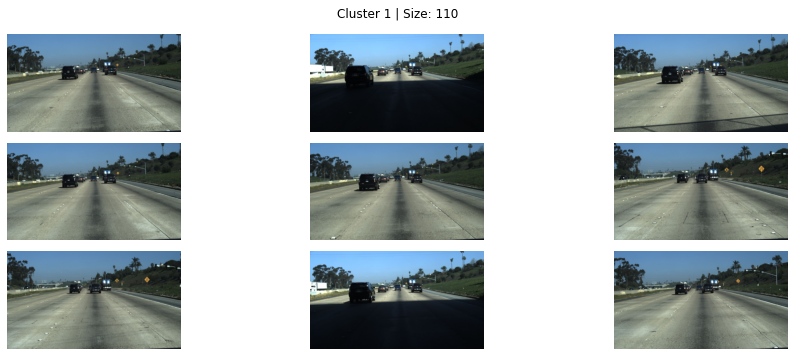

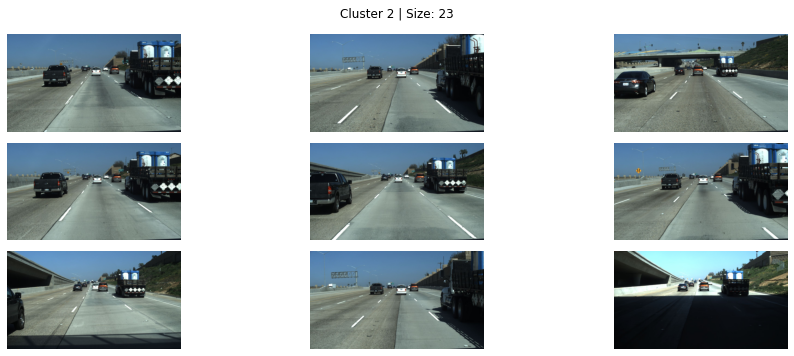

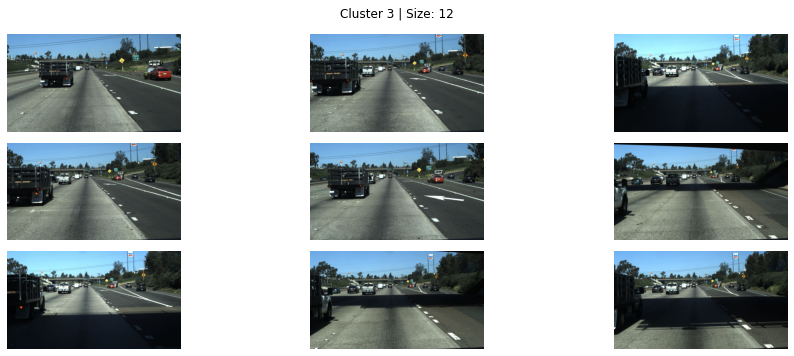

In [33]:
# show images from rarest clusters
n_clusters_to_visualize = 5
print('Visualizing rarest clusters of dataset samples...')
for i in range(min(n_clusters_to_visualize, len(unique_cluster_ids))):
    cluster_ids = np.array(train_ids)[labels == unique_cluster_ids[i]]
    # randomize the order of the images
    np.random.shuffle(cluster_ids)
    # show 9 images for this cluster
    plt.figure(figsize=(14,5))
    plt.suptitle('Cluster {} | Size: {}'.format(
        unique_cluster_ids[i], train_dataset_cluster_info[cluster_ids[0]]['cluster_size']))
    for j in range(min(9, len(cluster_ids))):
        filename = dataset.files[cluster_ids[j]]
        img = Image.open(filename)
        plt.subplot(3,3,j+1)
        plt.imshow(img)
        plt.axis('off')
    plt.tight_layout()
plt.show()

# show images from most likely clusters
n_clusters_to_visualize = 5
print('Visualizing most likely clusters of dataset samples...')
reversed_unique_cluster_ids = list(reversed(unique_cluster_ids))
for i in range(min(n_clusters_to_visualize, len(reversed_unique_cluster_ids))):
    cluster_ids = np.array(train_ids)[labels == reversed_unique_cluster_ids[i]]
    # randomize the order of the images
    np.random.shuffle(cluster_ids)
    # show 9 images for this cluster
    plt.figure(figsize=(14,5))
    plt.suptitle('Cluster {} | Size: {}'.format(
        train_dataset_cluster_info[cluster_ids[0]]['cluster_id'], 
        train_dataset_cluster_info[cluster_ids[0]]['cluster_size']))
    for j in range(min(9, len(cluster_ids))):
        filename = dataset.files[cluster_ids[j]]
        img = Image.open(filename)
        plt.subplot(3,3,j+1)
        plt.imshow(img)
        plt.axis('off')
    plt.tight_layout()
plt.show()